> This is a rework of my task during Machine Learning class in 2022.

> Goal(s):
- to construct a model using the Gradient Descent based Logistic Regression approach (scratch) to classify the given dataset (whether the score of student should be accepted or rejected).

> Requirement(s):
- the dataset should be split into training and validation sets.
- the performance of the regression model should be evaluated using a confusion matrix (CM).
- standardize the data before proceeding with the training and validation process.

> References **[A]**:
1.  https://www.scribbr.com/statistics/correlation-coefficient/
2.  https://www.statology.org/multicollinearity-regression/
3.  https://online.stat.psu.edu/stat462/node/180/
4.  https://stephenallwright.com/interpret-auc-score/

> References **[B]**:
*  Class/University notes
*  https://medium.com/analytics-vidhya/logistic-regression-with-gradient-descent-explained-machine-learning-a9a12b38d710
*  https://web.stanford.edu/~jurafsky/slp3/5.pdf

# Import Essentials

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Dataset

In [2]:
column_names = ['x1', 'x2', 'y']
data = pd.read_csv('../dataset/Mark.txt', sep=',', header=None, names=column_names)
data.head()

,x1,x2,y
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
data['y'].value_counts()

y
1    60
0    40
Name: count, dtype: int64

> The data class is distributed quite well.

In [4]:
def split_dataset(x, y, size, state=np.random.randint(0, 100)):
  data_A_X, data_B_X, data_A_Y, data_B_Y = train_test_split(x, y, train_size = size, random_state = state, stratify = y)
  data_A = pd.concat([data_A_X, data_A_Y], axis=1)
  data_B = pd.concat([data_B_X, data_B_Y], axis=1)
  return data_A, data_B

In [5]:
data_train, data_test = split_dataset(data.drop(columns='y'), data['y'], 0.8, 57)

> Dividing the raw data into training and testing sets using a 4:1 ratio.

# Dataset Overview

In [6]:
data_train.head()

,x1,x2,y
72,72.346494,96.227593,1
27,93.114389,38.800670,0
3,60.182599,86.308552,1
41,51.547720,46.856290,0
81,94.834507,45.694307,1


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 72 to 23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      80 non-null     float64
 1   x2      80 non-null     float64
 2   y       80 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


> This training dataset consists of both independent (all numerical) and dependent variables of equal length with no null values. Therefore, there is no need to proceed to the Handling Missing/Error Value step.

In [8]:
data_train.describe()

,x1,x2,y
count,80.000000,80.000000,80.000000
mean,64.790744,66.790377,0.600000
std,18.777791,17.962607,0.492989
min,30.058822,38.225278,0.000000
25%,50.515631,49.751648,0.000000
50%,65.368942,67.682381,1.000000
75%,79.260757,78.551368,1.000000
max,99.315009,97.718692,1.000000


In [9]:
numvar_col = ['x1', 'x2']

# Exploratory Data Analysis (EDA)

In [10]:
def visualize_numvar(df, col_names, col_target, type):
  data = df[col_names]
  rows = np.ceil((len(data.columns)) / 2).astype(int)
  fig, axs = plt.subplots(rows, 2, figsize=(6, 3))
  axs = axs.flatten()
  for idx, col_name in enumerate(col_names):
    if(type == 'dist'):
      sns.histplot(data[col_name], ax=axs[idx], kde=True)
      axs[idx].set_title(f"Distribution Plot ({col_name})")
    elif(type == 'box'):
      sns.boxplot(x=df[col_target], y=data[col_name], ax=axs[idx])
      axs[idx].set_title(f"Box Plot ({col_name})")
    elif(type == 'scatter'):
      sns.scatterplot(data[col_name], ax=axs[idx])
      axs[idx].set_title(f"Scatter Plot ({col_name})")
  plt.tight_layout()
  plt.show()

## Distribution Plot

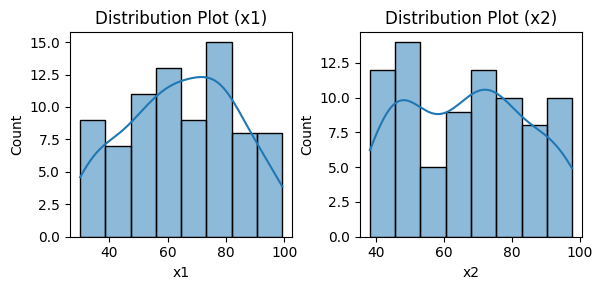

In [11]:
visualize_numvar(data_train, numvar_col, 'y', 'dist')

## Box Plot

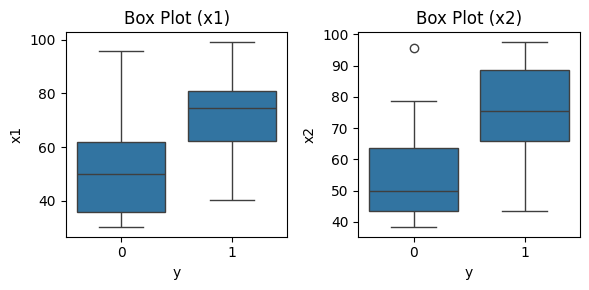

In [12]:
visualize_numvar(data_train, numvar_col, 'y', 'box')

> Based on the graph above, it seems like there is some outliers on this dataset. However, since the dataset is pretty small, removing outliers may not an urgent step to do.

## Scatter Plot

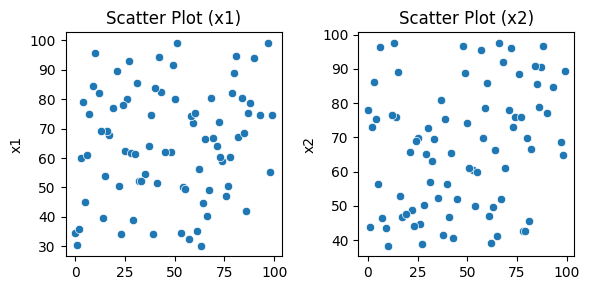

In [13]:
visualize_numvar(data_train, numvar_col, 'y', 'scatter')

## Correlation Analysis

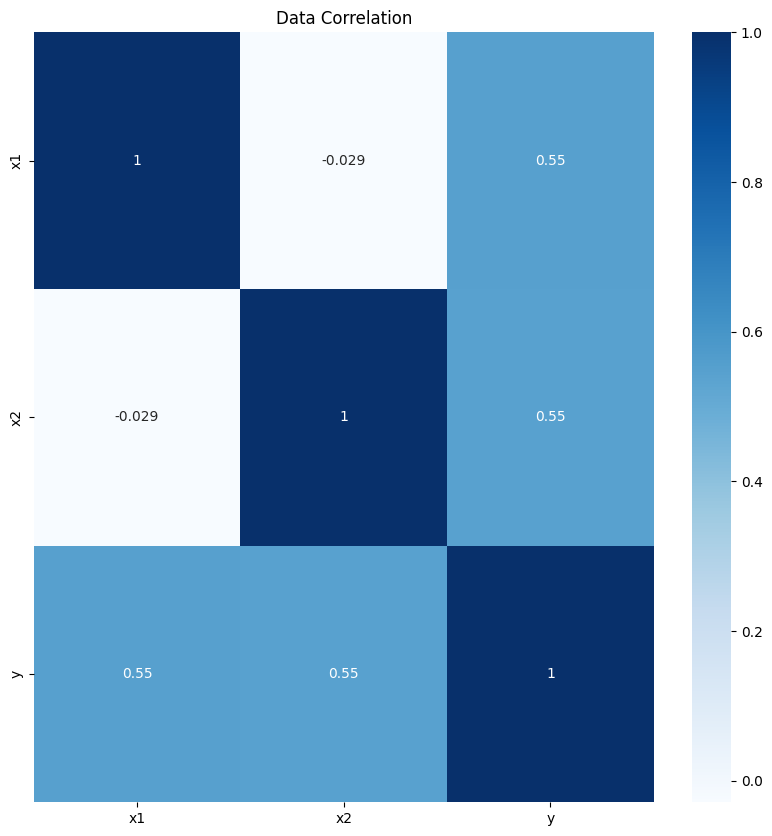

In [14]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_train.corr(), cmap='Blues', annot=True) 
plt.title('Data Correlation')
plt.show()

> It's noteworthy that the correlation between the independent variables and dependent variable is 0.55, which indicate a strong positive relationship [1].

In [15]:
def generate_VIF(data):
  vif_data = pd.DataFrame({
    'feature' : data.columns,
    'VIF' : [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
  })
  print(vif_data)

In [16]:
generate_VIF(data_train)

  feature       VIF
0      x1  7.807861
1      x2  7.687401
2       y  3.709943


> The obtained Variance Inflation Factor (VIF) for independent variables in the dataset ranges from 7.687401 to 7.807861, which indicate a potentially severe correlation [2]. However, it’s important to note that the general rule of thumb is that VIFs exceeding 4 warrant further investigation, while VIFs exceeding 10 are signs of serious multicollinearity requiring correction [3]. Therefore, based on this result, it can be concluded that each variable brings some unique information to the model, but the level of multicollinearity is not high enough to distort the model significantly.

## Visualizing

In [17]:
def visualize(data, title, column_name, xlabel, ylabel):
  groups_train = data.groupby(column_name)
  colors = {0 : 'red', 1 : 'blue'}
  for key, data in groups_train:
    plt.scatter(data[xlabel], data[ylabel], label = key, color = colors[key])
  plt.legend()
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

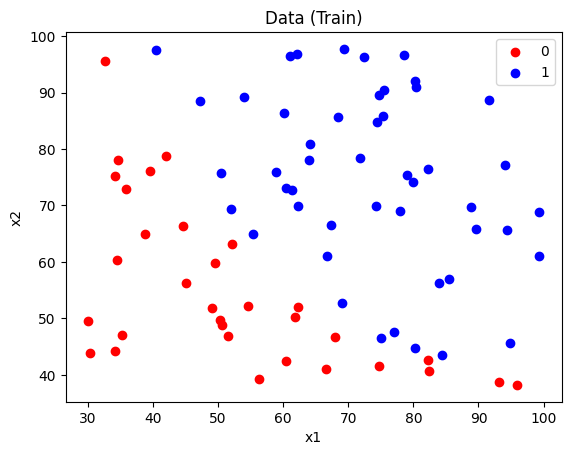

In [18]:
visualize(data_train, 'Data (Train)', 'y', 'x1', 'x2')

# Feature Transformation

In [19]:
scalar = StandardScaler()

In [20]:
data_train[data_train.columns.difference(['y'])] = scalar.fit_transform(data_train.drop(columns='y'))
data_train.head()

,x1,x2,y
72,0.404916,1.649145,1
27,1.517875,-1.568052,0
3,-0.246952,1.093456,1
41,-0.709699,-1.116756,0
81,1.610057,-1.181854,1


# Data Splitting

In [21]:
data_train, data_valid = split_dataset(data_train.drop(columns='y'), data_train['y'], 0.75, 1)

> Dividing the training data into training and validation sets using a 3:1 ratio.

# Model Building

## Explanation

> Here is $z$, a linear combination which also often called as logit, where $w$ as weight, $x$ as input feature(s), and $b$ as bias.

> 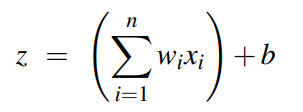

> To create a probability, we need to pass $z$ through the sigmoid function, which also often called as logistic function. This formula transform into a probability range between 0 and 1, which the result can be used as predicted value of y.

> 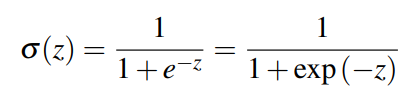

> In order to know the difference between the predicted value of y and the actual value of y, since there are only 2 outcomes, we can use Bernoulli Distribution where is $p$ is the probability of success and $1-p$ is the probability of failure.

> $P(Y = y) = p^y * (1-p)^{1-y}$

> Then, the maximum likelihood as follow:

> $L(β) = Π_{i=1}^n p_i^{y_i} * (1-p_i)^{1-y_i}$

> Finally, using log on both side to simplify the equation as follow:

> $l(β) = Σ_{i=1}^n y_i * log(p_i) + (1-y_i) * log(1-p_i)$

> To turn this into a loss function (loss):

> 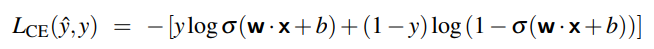

> Next, to optimize the model, then we need to minimize the loss, which we can do by finding the optimal weights and bias:

> 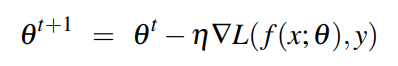

> 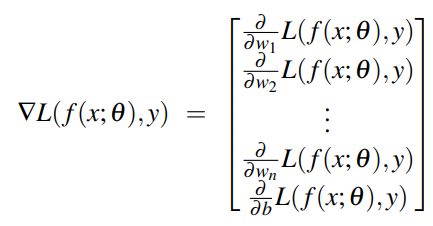

> 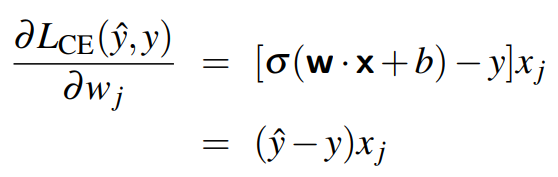

## Finding Parameters

In [22]:
class logistic_regression:
  def __init__(self, w, b):
    self.w = w
    self.b = b

  def sigmoid(self, x):
    return (1 / (1 + np.exp(-1 * (np.dot(x, self.w) + self.b))))

  def update_w(self, x, y, y_predict):
    return np.dot((y_predict - y), x)

  def update_b(self, y, y_predict):
    return sum(y_predict - y)

  def loss_function(self, y, y_predict):
    return (-1 * sum(y * np.log(y_predict) + (1 - y) * np.log(1 - y_predict)))

  def fit(self, x, y, learn_rate, epochs):
    loss = []
    for i in range(epochs):
      y_predict = self.sigmoid(x)
      self.b = self.b - learn_rate * self.update_b(y, y_predict)
      self.w = self.w - learn_rate * self.update_w(x, y, y_predict)
      loss.append(self.loss_function(y, y_predict))
    return loss

In [23]:
def loss_visualization(loss, learn_rate, epochs):
  for i in range(len(loss)):
    plt.plot(np.arange(1, epochs), loss[i][1:], label=learn_rate[i])
  plt.title('Number of Epochs vs Loss')
  plt.xlabel('Number of Epochs', size=10)
  plt.ylabel('Loss', size=10)
  plt.legend()

> Besides weights and bias, we also need to optimize the learning rate. In this case, we will try using several learning rates to see the most effective learning rates with this dataset.

In [24]:
losses, w, b = [], [], []
learn_rates = [0.005, 0.01, 0.05, 0.1, 0.3]
epochs = 5000

for i in range(len(learn_rates)):
  model = logistic_regression(np.zeros(data_train.drop(columns='y').shape[1]), 0)
  losses.append(model.fit(data_train.drop(columns='y'), data_train['y'], learn_rates[i], epochs))
  w.append(model.w)
  b.append(model.b)

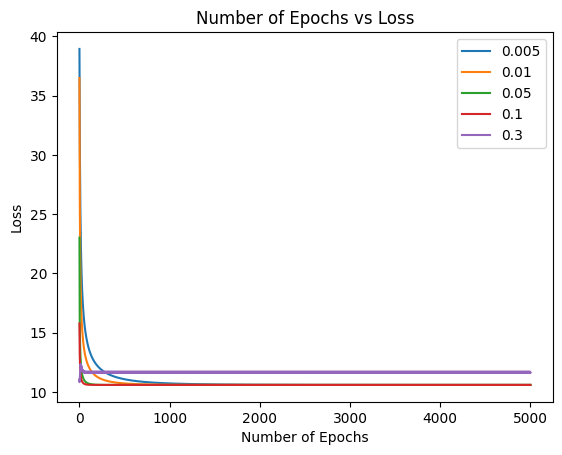

In [25]:
loss_visualization(losses, learn_rates, epochs)

In [26]:
loss = []
for i in range(len(learn_rates)):
  loss.append([learn_rates[i], losses[i][epochs - 2]])
loss = sorted(loss, key=lambda x:x[1])
print(f"Learning rate ({loss[0][0]}) produces smallest loss: {loss[0][1]}")

Learning rate (0.05) produces smallest loss: 10.593890905056625


> Based on the results above, it can be concluded that learning rate 0.05 is the most effective in minimizing the loss on this dataset (closest to 0). However, it is important to note that the loss score remains relatively high.

In [27]:
print(f"Weights: {w[2]}")
print(f"Bias: {b[2]}")

Weights: [4.33748818 5.22758694]
Bias: 2.3275612600714233


> This weights and bias will be used on the final model in the next part.

## Train The Final Model

In [28]:
loss = []
learn_rate = [0.05]
model_final = logistic_regression(w[2], b[2])
loss.append(model_final.fit(data_train.drop(columns='y'), data_train['y'], learn_rates[0], epochs))

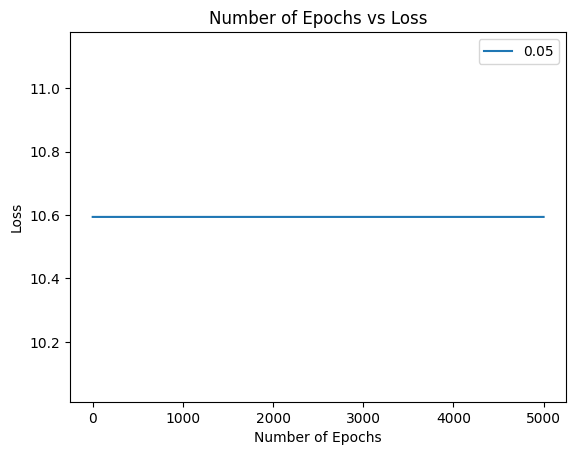

In [29]:
loss_visualization(loss, learn_rate, epochs)

> The loss score remains constant during the training of the final model, indicating that the model parameters have likely converged and further training does not significantly reduce the loss.

In [30]:
print(f"Weights: {model_final.w}")
print(f"Bias: {model_final.b}")

Weights: [4.33748818 5.22758694]
Bias: 2.3275612600714233


# Model Evaluation

In [31]:
def threshold(y):
  return [0 if y[i] <= 0.5 else 1 for i in range(y.size)]

In [32]:
data_valid['y predict'] = threshold(model_final.sigmoid(data_valid.drop(columns='y')))
data_valid.head()

,x1,x2,y,y predict
45,-0.137624,-0.825176,0,0
64,-1.078372,-0.019064,0,0
19,0.653162,-1.076438,1,0
22,-0.763982,-1.004738,0,0
74,-0.318851,0.508016,1,1


In [33]:
def conf_matrix(data_A, data_B):
  sns.heatmap(confusion_matrix(data_A, data_B), annot = True, cmap = 'Greys')
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Values')
  plt.ylabel('Actual Values')
  plt.show()

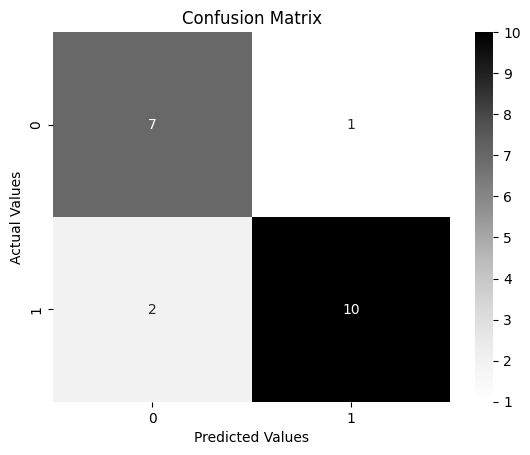

In [34]:
conf_matrix(data_valid['y'], data_valid['y predict'])

In [35]:
print(classification_report(data_valid.iloc[:, -2], data_valid.iloc[:, -1]))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.91      0.83      0.87        12

    accuracy                           0.85        20
   macro avg       0.84      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



In [36]:
print(f"ROC AUC score: {roc_auc_score(data_valid['y'], data_valid['y predict']):.3f}")

ROC AUC score: 0.854


> This model achieved a Receiver Operating Characteristic Area Under the Curve (ROC AUC) score of 0.854. This indicates that the model has an excellent discriminative ability, being able to perfectly distinguish between the classes in the dataset [4]. In addition, this model also achieved a great F1 score ranges from 0.82 to 0.87 and a great accuracy score of 85%. The confusion matrix further confirms the model’s performance on this dataset.

> Hence, it can be concluded that this final model made accurate predictions that closely match with the actual values.

## Predict using Test Dataset

In [37]:
data_test[data_test.columns.difference(['y'])] = scalar.fit_transform(data_test.drop(columns='y'))
data_test.head()

,x1,x2,y
70,-1.681735,-0.997288,0
11,0.275630,-1.611080,0
75,1.424117,0.406851,1
83,-0.547056,-0.214239,1
96,-1.240243,1.118756,1


In [38]:
data_test['y predict'] = threshold(model_final.sigmoid(data_test.drop(columns='y')))
data_test.head()

,x1,x2,y,y predict
70,-1.681735,-0.997288,0,0
11,0.275630,-1.611080,0,0
75,1.424117,0.406851,1,1
83,-0.547056,-0.214239,1,0
96,-1.240243,1.118756,1,1


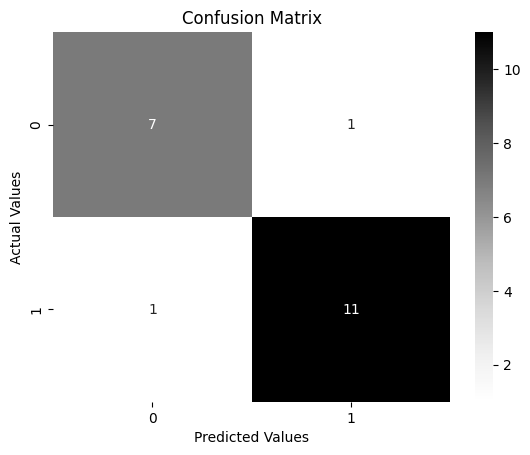

In [39]:
conf_matrix(data_test['y'], data_test['y predict'])

In [40]:
print(classification_report(data_test.iloc[:, -2], data_test.iloc[:, -1]))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.92      0.92      0.92        12

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



In [41]:
print(f"ROC AUC score: {roc_auc_score(data_test['y'], data_test['y predict']):.3f}")

ROC AUC score: 0.896


> This model achieved a Receiver Operating Characteristic Area Under the Curve (ROC AUC) score of 0.896. This indicates that the model has an excellent discriminative ability, being able to perfectly distinguish between the classes in the dataset [4]. In addition, this model also achieved an excellent F1 score ranges from 0.88 to 0.92 and an excellent accuracy score of 90%. The confusion matrix further confirms the model's performance on this dataset.

> Hence, it can be concluded that this final model made accurate predictions that closely match with the actual values.

> In conclusion, the model has shown a high level of performance in both the validation and testing phases. It has proven to be effective in making accurate predictions that closely align with the actual values. Therefore, it can be confidently used for further predictions.

> After obtaining the y values as the prediction results from the testing dataset, visualization will be conducted.

## Visualize Data (Testing Dataset)

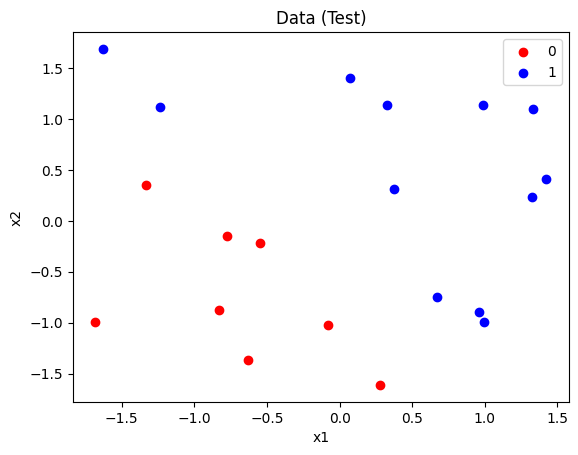

In [42]:
visualize(data_test, 'Data (Test)', 'y predict', 'x1', 'x2')

# Visualization

In [43]:
data = pd.concat([data_valid, data_test])

In [44]:
def visualize_final(data, title, column_name, xlabel, ylabel):
  xl = np.array([min(min(data[xlabel]), min(data[ylabel])), max(max(data[xlabel]), max(data[ylabel]))])
  line = -1 * (model_final.b + model_final.w[0] * xl) / model_final.w[1]
  plt.plot(xl, line, color = 'black', linestyle = 'dashed')
  visualize(data, title, column_name, xlabel, ylabel)
  plt.show()

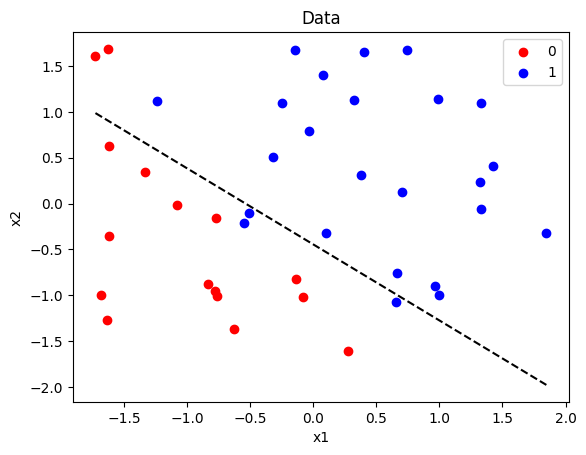

In [45]:
visualize_final(data, 'Data', 'y', 'x1', 'x2')